In [1]:
from IPython.display import display, HTML

display(
    HTML("""
<style>
div.container{width:80% !important;}
div.prompt {min-width:70px;}
div#toc-header{margin-top:150px;}
span.toc-item-num{display:none;}
div.CodeMirror {font-family:Consolas}
div.input {font-family:Consolas}
</style>
"""))

- iris 데이터 종 예측

In [2]:
import seaborn as sns  # iris 데이터 가져오기
import pandas as pd    # 원핫인코딩(문자pd.get_dummies())
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')

# 독립변수와 종속변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()  # 독립변수
iris_y = iris.iloc[:, -1]              # 종속변수(원핫인코딩을 위해 1차원으로 생성)

# 원핫인코딩
iris_Y = pd.get_dummies(iris_y).values # 2차원 배열
# iris_Y[::50]

# 훈련셋 : 테스트셋 = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y, 
                                                    test_size=0.2, 
                                                    stratify=iris_Y,  # 층화추출 : 모집단을 먼저 서로 겹치지 않는 여러 개의 층으로 분할한 후, 
                                                                      #           각 층에서 단순 임의추출법에 따라 배정된 표본을 추출하는 방법
                                                    random_state=4)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

In [4]:
# 층화추출을 했는지 확인
pd.Series(np.argmax(Y_train, axis=1)).value_counts()

0    40
1    40
2    40
dtype: int64

In [5]:
pd.Series(np.argmax(Y_test, axis=1)).value_counts()

1    10
2    10
0    10
dtype: int64

In [6]:
# 2. 모델 구성하기 (입력4 - 출력3)
model = Sequential()
model.add(Dense(units=60, input_dim=4, activation='relu'))     # 입력층
model.add(Dense(units=50,              activation='relu'))
model.add(Dense(units=30,              activation='relu'))
model.add(Dense(units=3,               activation='softmax'))  # 출력층
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                300       
                                                                 
 dense_1 (Dense)             (None, 50)                3050      
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 3)                 93        
                                                                 
Total params: 4,973
Trainable params: 4,973
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# 2. 모델 구성하기 (입력4 - 출력3)
model = Sequential([
    Input(4, ),
    Dense(units=60, activation='relu'),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dropout(0.1),
    Dense(units=3,  activation='softmax'),
])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 60)                300       
                                                                 
 dense_5 (Dense)             (None, 128)               7808      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                

In [8]:
# 3. 모델 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
                                                                # accuracy, recall, precision, f1_score(함수)

In [9]:
# 4. 모델 학습시키기 : epoch마다 val_accuracy(val_loss, accuracy, loss)값이 좋을 때 모델을 자동 저장하는 콜백 추가
# 모델을 저장할 경로 : ./model/iris-100-val0.6521.h5
import os
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlystopping = EarlyStopping(patience=100, monitor='val_loss')  # monitor='val_loss' : 기본값
# 모델 자동 저장 콜백 객체 생성
file = model_save_folder + 'iris-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,           # 저장경로
                             monitor='val_accuracy',  # 모니터링할 지표
                             save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                             mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbose=1)               # 저장 여부 로그 출력 (0:출력 안 함)
hist = model.fit(X_train, Y_train,
                 # batch_size=50,  # 한 배치사이즈마다 w, b값 조정
                 epochs=500,
                 validation_split=0.2,
                 callbacks=[checkpoint, earlystopping])

Epoch 1/500
1/3 [=========>....................] - ETA: 1s - loss: 1.1040 - accuracy: 0.3438
Epoch 1: val_accuracy improved from -inf to 0.70833, saving model to ./model\iris-001-val0.7083.h5
3/3 [==============================] - 1s 175ms/step - loss: 1.0523 - accuracy: 0.4167 - val_loss: 0.9344 - val_accuracy: 0.7083
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0608 - accuracy: 0.3125
Epoch 2: val_accuracy did not improve from 0.70833
3/3 [==============================] - 0s 25ms/step - loss: 1.0288 - accuracy: 0.4167 - val_loss: 0.8645 - val_accuracy: 0.7083
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.9578 - accuracy: 0.4062
Epoch 3: val_accuracy improved from 0.70833 to 0.91667, saving model to ./model\iris-003-val0.9167.h5
3/3 [==============================] - 0s 33ms/step - loss: 0.9483 - accuracy: 0.4583 - val_loss: 0.8170 - val_accuracy: 0.9167
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 0.8495 - accuracy

3/3 [==============================] - 0s 17ms/step - loss: 0.2189 - accuracy: 0.8958 - val_loss: 0.0561 - val_accuracy: 1.0000
Epoch 31/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3428 - accuracy: 0.8438
Epoch 31: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 25ms/step - loss: 0.2619 - accuracy: 0.8958 - val_loss: 0.0856 - val_accuracy: 1.0000
Epoch 32/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1252 - accuracy: 0.9375
Epoch 32: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.1550 - accuracy: 0.9271 - val_loss: 0.0858 - val_accuracy: 1.0000
Epoch 33/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2021 - accuracy: 0.8750
Epoch 33: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.1811 - accuracy: 0.9167 - val_loss: 0.0523 - val_accuracy: 1.0000
Epoch 34/500
1/3 [=========>....................] 

3/3 [==============================] - 0s 17ms/step - loss: 0.1435 - accuracy: 0.9271 - val_loss: 0.0719 - val_accuracy: 0.9583
Epoch 61/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1609 - accuracy: 0.9688
Epoch 61: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.0960 - accuracy: 0.9688 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 62/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0245 - accuracy: 1.0000
Epoch 62: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.1146 - accuracy: 0.9688 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 63/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0708 - accuracy: 0.9688
Epoch 63: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.1341 - accuracy: 0.9583 - val_loss: 0.0460 - val_accuracy: 1.0000
Epoch 64/500
1/3 [=========>....................] 

3/3 [==============================] - 0s 16ms/step - loss: 0.0845 - accuracy: 0.9792 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 91/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - accuracy: 1.0000
Epoch 91: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0980 - accuracy: 0.9688 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 92/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1199 - accuracy: 0.9688
Epoch 92: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0890 - accuracy: 0.9688 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 93/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1564 - accuracy: 0.9375
Epoch 93: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0818 - accuracy: 0.9792 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 94/500
1/3 [=========>....................] 

1/3 [=========>....................] - ETA: 0s - loss: 0.0332 - accuracy: 1.0000
Epoch 120: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0654 - accuracy: 0.9792 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 121/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0672 - accuracy: 1.0000
Epoch 121: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 19ms/step - loss: 0.0668 - accuracy: 0.9896 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 122/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - accuracy: 1.0000
Epoch 122: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.1045 - accuracy: 0.9688 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 123/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1889 - accuracy: 0.9375
Epoch 123: val_accuracy did not improve from 1.00000
3/3 [==============================] -

Epoch 150/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - accuracy: 1.0000
Epoch 150: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 33ms/step - loss: 0.0709 - accuracy: 0.9896 - val_loss: 0.0158 - val_accuracy: 1.0000
Epoch 151/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1401 - accuracy: 0.9688
Epoch 151: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 25ms/step - loss: 0.0629 - accuracy: 0.9896 - val_loss: 0.0242 - val_accuracy: 1.0000
Epoch 152/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0407 - accuracy: 0.9688
Epoch 152: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 25ms/step - loss: 0.0909 - accuracy: 0.9688 - val_loss: 0.0212 - val_accuracy: 1.0000
Epoch 153/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0517 - accuracy: 0.9688
Epoch 153: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 180/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0974 - accuracy: 0.9688
Epoch 180: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0580 - accuracy: 0.9896 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 181/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1065 - accuracy: 0.9375
Epoch 181: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 15ms/step - loss: 0.0497 - accuracy: 0.9792 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 182/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000
Epoch 182: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0544 - accuracy: 0.9792 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 183/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0432 - accuracy: 1.0000
Epoch 183: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 210/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - accuracy: 1.0000
Epoch 210: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.0733 - accuracy: 0.9896 - val_loss: 0.0147 - val_accuracy: 1.0000
Epoch 211/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - accuracy: 1.0000
Epoch 211: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0644 - accuracy: 0.9896 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 212/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1310 - accuracy: 0.9688
Epoch 212: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 25ms/step - loss: 0.0621 - accuracy: 0.9896 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 213/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - accuracy: 1.0000
Epoch 213: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 240/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0374 - accuracy: 1.0000
Epoch 240: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0544 - accuracy: 0.9896 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 241/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0268 - accuracy: 1.0000
Epoch 241: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0489 - accuracy: 0.9896 - val_loss: 0.0180 - val_accuracy: 1.0000
Epoch 242/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - accuracy: 1.0000
Epoch 242: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0521 - accuracy: 0.9896 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 243/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0273 - accuracy: 1.0000
Epoch 243: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 270/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0616 - accuracy: 0.9688
Epoch 270: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0373 - accuracy: 0.9896 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 271/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1480 - accuracy: 0.9688
Epoch 271: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0731 - accuracy: 0.9896 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 272/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0285 - accuracy: 1.0000
Epoch 272: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0617 - accuracy: 0.9792 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 273/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - accuracy: 1.0000
Epoch 273: val_accuracy did not improve from 1.00000
3/3 [===================

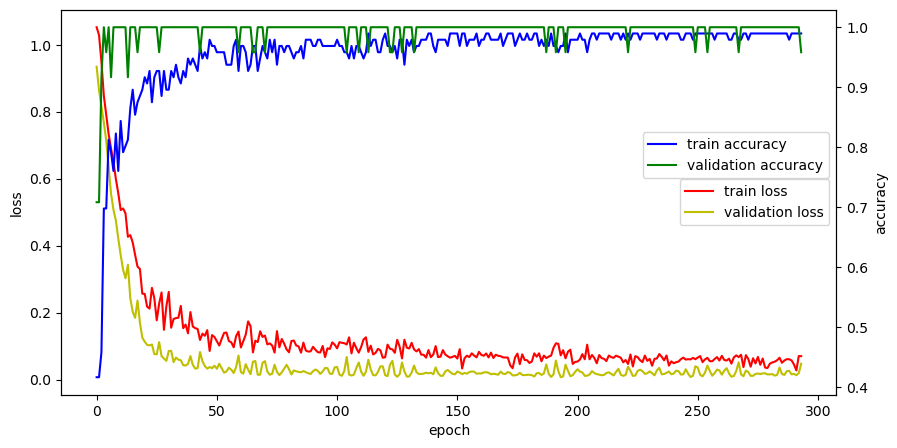

In [10]:
# 5. 모델 평가하기
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [11]:
# 모델 평가하기
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 17ms/step - loss: 0.1263 - accuracy: 0.9333


[0.12626488506793976, 0.9333333373069763]

In [12]:
# 교차표
real = np.argmax(Y_test, axis=1)  # 실제값
pred = np.argmax(model.predict(X_test), axis=1)  # 예측값
ctab = pd.crosstab(real, pred)
ctab.columns = list(iris['species'][::50])  # ['setosa', 'versicolor', 'virginica']
ctab.columns.name = 'predict'
ctab.index = iris['species'][::50]
ctab.index.name = 'real'
ctab

1/1 [==============================] - 0s 116ms/step


predict,setosa,versicolor,virginica
real,,,
setosa,10,0,0
versicolor,0,8,2
virginica,0,0,10


In [13]:
list(iris['species'][::50])

['setosa', 'versicolor', 'virginica']

In [14]:
# 저장된 모델 중 성능이 제일 좋아 보이는 것 load
from tensorflow.keras.models import load_model
model2 = load_model('model/iris1.h5')
model2.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 167ms/step - loss: 0.8775 - accuracy: 0.9667


[0.8774982690811157, 0.9666666388511658]

In [15]:
# 저장된 모델의 교차표
real = np.argmax(Y_test, axis=1)  # 실제값
pred = np.argmax(model2.predict(X_test), axis=1)  # 예측값
ctab = pd.crosstab(real, pred)
ctab.columns = list(iris['species'][::50])  # ['setosa', 'versicolor', 'virginica']
ctab.columns.name = 'predict'
ctab.index = iris['species'][::50]
ctab.index.name = 'real'
ctab

1/1 [==============================] - 0s 68ms/step


predict,setosa,versicolor,virginica
real,,,
setosa,10,0,0
versicolor,0,9,1
virginica,0,0,10


In [16]:
# 모델 사용하기(예측하기)
iris[10:11]

,sepal_length,sepal_width,petal_length,petal_width,species
10,5.4,3.7,1.5,0.2,setosa


In [17]:
model.predict(np.array([[5.4, 3.7, 1.5, 0.2]]))

1/1 [==============================] - 0s 18ms/step


array([[1.0000000e+00, 4.8358462e-10, 2.1468032e-17]], dtype=float32)